##Import Dataset From Kaggle

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sonalshinde123/tiger-vs-lion-image-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 7.05M/7.05M [00:00<00:00, 125MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sonalshinde123/tiger-vs-lion-image-classification-dataset/versions/1


##Important Libraries

In [24]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

##Auto-Detect Dataset Root

In [15]:
def find_dataset_root(base_path):
    for root, dirs, files in os.walk(base_path):
        if set(dirs) >= {"lion", "tiger"}:
            return root
        if set(map(str.lower, dirs)) >= {"lion", "tiger"}:
            return root
    raise FileNotFoundError("Could not locate lion/tiger dataset folders.")

DATASET_PATH = find_dataset_root(path)
print("Detected dataset path:", DATASET_PATH)

Detected dataset path: /root/.cache/kagglehub/datasets/sonalshinde123/tiger-vs-lion-image-classification-dataset/versions/1/lion_tiger_dataset


##Normalize Class Folder Names

In [16]:
for cls in os.listdir(DATASET_PATH):
    old = os.path.join(DATASET_PATH, cls)
    new = os.path.join(DATASET_PATH, cls.lower())
    if cls.lower() != cls:
        os.rename(old, new)

print("Final dataset folders:", os.listdir(DATASET_PATH))


Final dataset folders: ['tiger', 'lion']


##Config

In [17]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 15

##Data Generator


In [18]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

print("Class mapping:", train_gen.class_indices)

Found 368 images belonging to 2 classes.
Found 92 images belonging to 2 classes.
Class mapping: {'lion': 0, 'tiger': 1}


##Model

In [19]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,610 (18.42 MB)

 Trainable params: 4,828,610 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

##Train

In [20]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5272 - loss: 1.1973 - val_accuracy: 0.5000 - val_loss: 0.6981
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4358 - loss: 0.6982 - val_accuracy: 0.5000 - val_loss: 0.6895
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5265 - loss: 0.6861 - val_accuracy: 0.4891 - val_loss: 0.6870
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5221 - loss: 0.6882 - val_accuracy: 0.5000 - val_loss: 0.6996
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5740 - loss: 0.6773 - val_accuracy: 0.8152 - val_loss: 0.5796
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6266 - loss: 0.6473 - val_accuracy: 0.8261 - val_loss: 0.4674
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7926 - loss: 0.4713 - val_accuracy: 0.8587 - val_loss: 0.3704
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8058 - loss: 0.4686 - val_accuracy: 0.8804 - val_loss:

##Training Curves

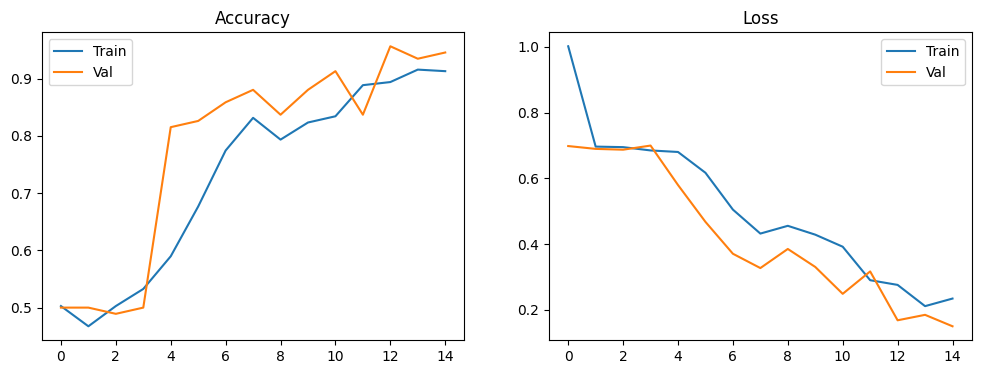

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.show()

##Prediction Function

In [22]:
def predict_image(img_path, threshold=0.7):
    if not os.path.exists(img_path):
        print("Image not found:", img_path)
        return

    img = image.load_img(img_path, target_size=IMG_SIZE)
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    preds = model.predict(arr)
    idx = np.argmax(preds)
    conf = preds[0][idx]

    labels = list(train_gen.class_indices.keys())

    if conf < threshold:
        label = "Uncertain"
    else:
        label = labels[idx]

    print(f"Prediction: {label} | Confidence: {conf:.2f}")

    plt.imshow(img)
    plt.axis("off")
    plt.show()


##Sample Visualization

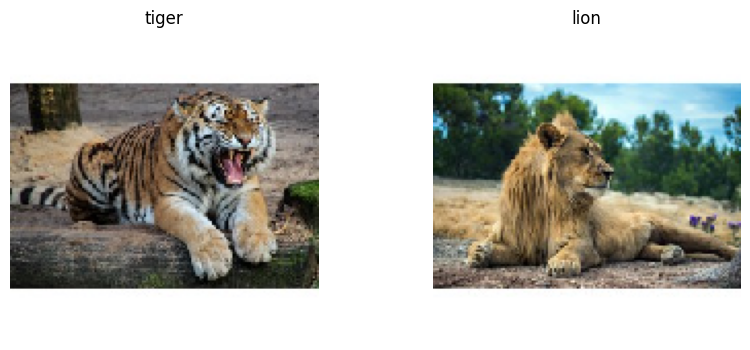

In [25]:
plt.figure(figsize=(10,4))
for i, cls in enumerate(os.listdir(DATASET_PATH)):
    img_name = random.choice(os.listdir(os.path.join(DATASET_PATH, cls)))
    img_path = os.path.join(DATASET_PATH, cls, img_name)

    img = image.load_img(img_path, target_size=IMG_SIZE)
    plt.subplot(1,2,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()

##Test Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Prediction: tiger | Confidence: 1.00


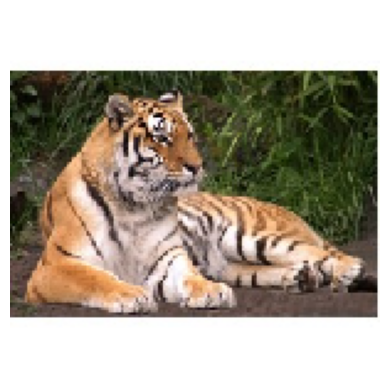

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction: Uncertain | Confidence: 0.68


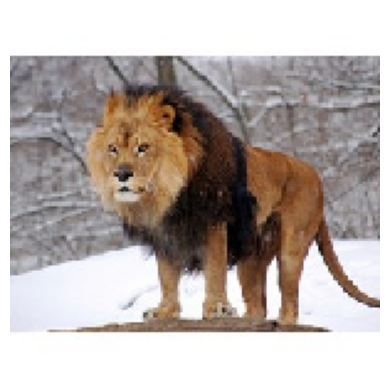

In [26]:
for cls in os.listdir(DATASET_PATH):
    img_name = random.choice(os.listdir(os.path.join(DATASET_PATH, cls)))
    img_path = os.path.join(DATASET_PATH, cls, img_name)
    predict_image(img_path)